In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import numpy as np

In [2]:
url = 'https://www.worldometers.info/coronavirus/'
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
_dict = {}
save_csv = True
append_csv = True
percentile = 97

In [3]:
page = requests.get(url)
soup = BeautifulSoup(page.content)

In [4]:
for _tr_list in soup.tbody.find_all('tr'):
    _td_list = _tr_list.find_all('td')
    for i, _td in enumerate(_td_list):        
        # Recuperar el nombre del pais cuando es un enlace
        if i%9 == 0:
            _a = _td.find('a')
                # Recuperar el nombre del pais cuando es un enlace
            if _a:
                country_name = _a['href'].split('/')[1]
            else:
                _span = _td.find('span')
                if _span:
                    # Recuperar el nombre del cuando ocupa dos filas
                    country_name = _span.contents[0]
                else:
                     # Recuperar el nombre del pais cuando no es un enlace
                    country_name = _td.contents[0]
            if country_name:
                country_name = country_name.strip()
                if country_name not in list(_dict.keys()):
                    _dict[country_name] = {} 
                _dict[country_name][now] = []
        # Recuperar los datos del pais
        else:
            if len(_td.contents) > 0:
                # Limipiar el dato de cualquier símbolo para poder convertirlo en un valor numérico
                data = _td.contents[0].replace('+','').replace(',','').strip()
                if data:
                    _dict[country_name][now].append(float(data))
                else:
                    _dict[country_name][now].append(0)
            else:
                _dict[country_name][now].append(0)

In [5]:
# https://stackoverflow.com/questions/13575090/construct-pandas-dataframe-from-items-in-nested-dictionary
df = pd.concat({k: pd.DataFrame(v).T for k, v in _dict.items()}, axis=0)
df.columns = ['total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_recovered', 'active_cases', 'servious_critical', 'total_cases_1M_pop']
df.index.names = ['country', 'timestamp']
display(df.head())

,,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
country,timestamp,,,,,,,,
Afghanistan,2020-03-23 19:12:24,40.0,0.0,1.0,0.0,1.0,38.0,0.0,1.00
Albania,2020-03-23 19:12:24,104.0,15.0,4.0,2.0,2.0,98.0,2.0,36.00
Andorra,2020-03-23 19:12:24,133.0,20.0,1.0,0.0,1.0,131.0,2.0,1721.00
Angola,2020-03-23 19:12:24,2.0,0.0,0.0,0.0,0.0,2.0,0.0,0.06
Antigua and Barbuda,2020-03-23 19:12:24,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.00


In [6]:
if save_csv:
    if append_csv:
        print('Adding data to csv...')
        df.to_csv('covid-19_2020.csv', mode='a', header=False, index=True) 
    else:
        print('Creating csv...')
        df.to_csv('covid-19_2020.csv', index=True)    
else:
    print('Save csv not needed')

Adding data to csv...


In [7]:
df = pd.read_csv('covid-19_2020.csv')

In [8]:
df.head()

,country,timestamp,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
0,Afghanistan,2020-03-19 19:12:43,22.0,0.0,0.0,0.0,1.0,21.0,0.0,0.6
1,Albania,2020-03-19 19:12:43,64.0,5.0,2.0,0.0,0.0,62.0,2.0,22.0
2,Algeria,2020-03-19 19:12:43,90.0,15.0,9.0,2.0,32.0,49.0,0.0,2.0
3,Andorra,2020-03-19 19:12:43,53.0,0.0,0.0,0.0,1.0,52.0,0.0,686.0
4,Antigua and Barbuda,2020-03-19 19:12:43,1.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0


In [9]:
# Solo paises más significativos
df_significant = df[(df['total_cases'] > np.percentile(df['total_cases'], percentile))].sort_values(by = ['total_cases'], ascending=False)

# Se muestra el número de casos según el país ("country") para la última muestra
last_timestamp = list(df_significant['timestamp'])[0]
df_last_timestamp = df_significant[(df_significant['timestamp'] == last_timestamp)]
display(df_last_timestamp)

,country,timestamp,total_cases,new_cases,total_deaths,new_deaths,total_recovered,active_cases,servious_critical,total_cases_1M_pop
2615,china,2020-03-23 19:12:24,81093.0,39.0,3270.0,9.0,72703.0,5120.0,1749.0,56.0
2625,italy,2020-03-23 19:12:24,63927.0,4789.0,6077.0,601.0,7432.0,50418.0,3204.0,1057.0
2637,us,2020-03-23 19:12:24,41526.0,7980.0,501.0,82.0,187.0,40838.0,1040.0,125.0
2633,spain,2020-03-23 19:12:24,33089.0,4321.0,2207.0,435.0,3355.0,27527.0,2355.0,708.0
2619,germany,2020-03-23 19:12:24,28865.0,3992.0,118.0,24.0,422.0,28325.0,23.0,345.0
2622,iran,2020-03-23 19:12:24,23049.0,1411.0,1812.0,127.0,8376.0,12861.0,0.0,274.0
2618,france,2020-03-23 19:12:24,16689.0,671.0,860.0,186.0,2200.0,13629.0,1746.0,256.0


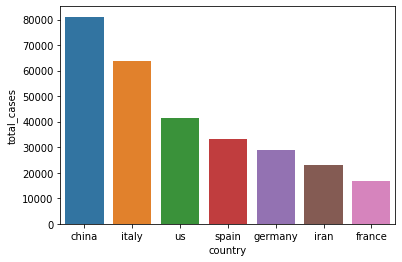

In [10]:
# Se representan gráficamente los resultados
# https://seaborn.pydata.org/generated/seaborn.barplot.html#seaborn.barplot
plot = sns.barplot(x="country", y="total_cases", data=df_last_timestamp)

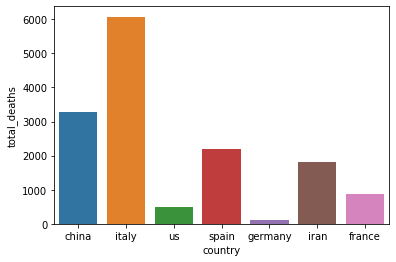

In [11]:
plot = sns.barplot(x="country", y="total_deaths", data=df_last_timestamp)

In [18]:
# Añadir dia (date)
df_significant['date'] = [timestamp.split()[0] for timestamp in df_significant['timestamp']]

# Agrupar por dia (date) utilizando el valor máximo del día
df_by_date = df_significant.groupby(['country','date']).max().round()
df_by_date = df_by_date.sort_values(by = ['total_cases'], ascending=False)

display(df_by_date.head())

timestamp  total_cases  new_cases  total_deaths  \
country date                                                                    
china   2020-03-23  2020-03-23 19:12:24      81093.0       39.0        3270.0   
        2020-03-22  2020-03-22 22:01:48      81054.0       46.0        3261.0   
        2020-03-21  2020-03-21 23:00:20      81008.0       41.0        3255.0   
        2020-03-20  2020-03-20 20:15:24      80967.0       39.0        3248.0   
        2020-03-19  2020-03-19 19:12:43      80928.0       34.0        3245.0   

                    new_deaths  total_recovered  active_cases  \
country date                                                    
china   2020-03-23         9.0          72703.0        5120.0   
        2020-03-22         6.0          72440.0        5353.0   
        2020-03-21         7.0          71740.0        6013.0   
        2020-03-20         3.0          71150.0        6569.0   
        2020-03-19         8.0          70420.0        7263.0   

                    servious_critical  total_cases_1M_pop  
country date                                               
china   2020-03-23             1749.0                56.0  
        2020-03-22             1845.0                56.0  
        2020-03-21             1927.0                56.0  
        2020-03-20             2136.0                56.0  
        2020-03-19             2274.0                56.0

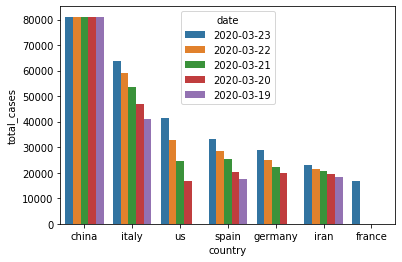

In [19]:
# Se muestra la evolución en el tiempo para cada país ("country")
# Se representan gráficamente los resultados
# 
plot = sns.barplot(x="country", y="total_cases", hue = "date", data=df_by_date.reset_index())

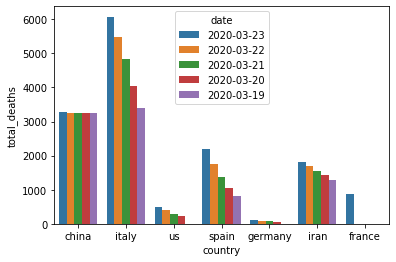

In [20]:
plot = sns.barplot(x="country", y="total_deaths", hue = "date", data=df_by_date.reset_index())

In [21]:
df_spain = df_by_date.loc['spain']

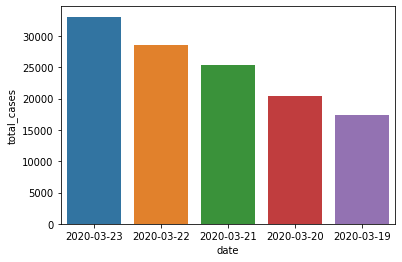

In [22]:
plot = sns.barplot(x='date', y="total_cases", data=df_spain.reset_index())

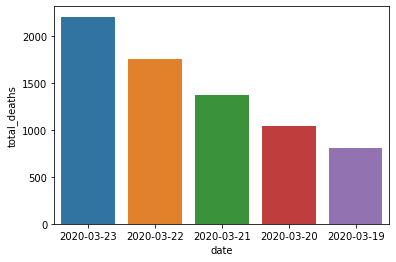

In [23]:
plot = sns.barplot(x='date', y="total_deaths", data=df_spain.reset_index())